<a href="https://colab.research.google.com/github/garrettwrong/cufinufft/blob/colab_sanity_check/2d_nufft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# We can install cufinufft via pip,
#   this also installs pycuda, which may take a while the first time.
%pip install cufinufft 

from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import scipy.linalg as LA
import numpy as np
from numpy import pi
import skimage

# Typical pycuda imports
import pycuda.autoinit
import pycuda.driver as cuda
import pycuda.gpuarray as gpuarray

# Bring in the cufinufft class
from cufinufft import cufinufft

# Get an example image

[[71. 71. 72. ... 73. 75. 76.]
 [71. 71. 71. ... 73. 75. 76.]
 [71. 71. 71. ... 73. 75. 76.]
 ...
 [68. 68. 68. ... 60. 60. 61.]
 [68. 68. 68. ... 59. 60. 61.]
 [68. 68. 68. ... 59. 60. 61.]]


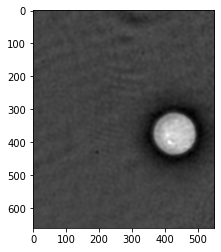

In [ ]:
# Import an example image.  The 'cell' is reasonable for our purposes.
img_data = skimage.data.cell()

# We'll also convert it to doubles
img_data = img_data.astype(np.float64)
print(img_data)

# and we Plot
plt.imshow(img_data, cmap='gray')
plt.show()

# Round trip transforms using numpy FFT

### Transform to Fourier space

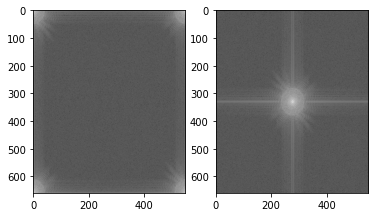

In [ ]:
# Compute the transform in numpy
f = np.fft.fft2(img_data)

# Shift zero freq to center
f_shifted = np.fft.fftshift(f)

# For visualization, we'll compute a more friendly range
spectrum = 20. * np.log(np.abs(f))
spectrum_shifted = 20. * np.log(np.abs(f_shifted))

# and we Plot
plt.subplot(121).imshow(spectrum, cmap='gray')
plt.subplot(122).imshow(spectrum_shifted, cmap='gray')
plt.show()

### Reconstruction

In [ ]:
# Shift it back
f = np.fft.ifftshift(f_shifted)

# Compute the inverse transform
reconstructed_img_data = np.real(np.fft.ifft2(f))

### Comparison

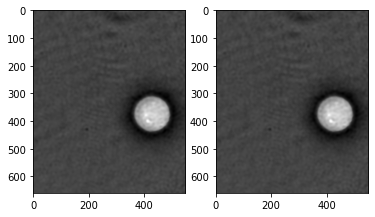

Reconstruction Close: True
Diffs l0: 252129.0    l1: 4.999958809944379e-09    l2: 1.0852458762007746e-11


In [ ]:
# Plot it
plt.subplot(121).imshow(img_data, cmap='gray')
plt.subplot(122).imshow(reconstructed_img_data, cmap='gray')
plt.show()

# Compute basic norms of delta between original and reconstruction.
print('Reconstruction Close:', np.allclose(img_data, reconstructed_img_data))
# How close?
diff = img_data - reconstructed_img_data
l0_norm = LA.norm(diff.ravel(), 0)
l1_norm = np.sum(np.abs(diff))
l2_norm = np.linalg.norm(diff)
print(f'Diffs l0: {l0_norm}    l1: {l1_norm}    l2: {l2_norm}')

# Round trip transforms with cufinufft

### Setup a mesh

In [ ]:
N = 1024   # 16384 gets you pretty close...
num_pts = N*N
M = np.random.uniform(-pi, pi, (2, num_pts))

### Move data to gpu

In [ ]:
# Fourier points
M_gpu = gpuarray.to_gpu(M)

# Signal data
img_data_gpu = gpuarray.to_gpu(img_data.astype(np.complex128))

# Create an array for the result on the GPU
nuf_gpu = gpuarray.GPUArray(num_pts, dtype=np.complex128)

### Setup and run a Type 2 transform
Uniform (Real Space) to Non Uniform (Fourier Space)

In [ ]:
# Set an output shape
shape = img_data.shape

plan = cufinufft(2, shape, -1, tol=1e-15, dtype=M_gpu.dtype)
plan.set_pts(num_pts, M_gpu[0], M_gpu[1])
plan.execute(nuf_gpu, img_data_gpu)
nuf = nuf_gpu.get()

# Check the max signal strengths look reasonable
#   Note for a course mesh, don't expect to be too close...
print(np.max(np.abs(nuf)))
print(np.max(np.abs(f)))


10931297.529001756
24669746.0


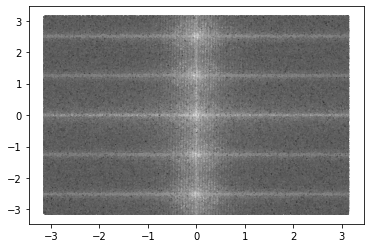

In [ ]:
# We can plot the (random) Fourier points.  This can take a while for large num_pts
tmp = 20. * np.log(np.abs(nuf))
plt.scatter(M[0], M[1], c=tmp, cmap='gray', marker='.', s=1)
plt.show()

### Setup and Run cufinufft, Type 1 transform
Non Uniform (Fourier Space) to Uniform (Real Space)

In [ ]:
# Create an array for the output on GPU
reconstructed_img_data_2_gpu = gpuarray.GPUArray(shape, dtype=np.complex128)

# Setup and run the plan
plan = cufinufft(1, shape, 1, tol=1e-15, dtype=np.float64)
plan.set_pts(num_pts, M_gpu[0], M_gpu[1])
plan.execute(nuf_gpu, reconstructed_img_data_2_gpu)

# Copy result to host for next steps
reconstructed_img_data_2 = reconstructed_img_data_2_gpu.get()

# Again, we'll normalize it for independence on number of fourier pts
reconstructed_img_data_2 = np.real(reconstructed_img_data_2) / num_pts

### Comparison

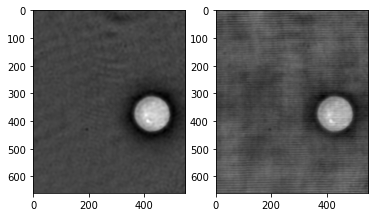

Reconstruction Close: False
Diffs l1: 18067589.526006386    l2: 31602.79972753345


In [ ]:
plt.subplot(121).imshow(reconstructed_img_data, cmap='gray')
plt.subplot(122).imshow(reconstructed_img_data_2, cmap='gray')
plt.show()

print('Reconstruction Close:', np.allclose(img_data, reconstructed_img_data_2))

diff = img_data - reconstructed_img_data_2
l1_norm = np.sum(np.abs(diff))
l2_norm = np.linalg.norm(diff)
print(f'Diffs l1: {l1_norm}    l2: {l2_norm}')


In [ ]:
print(img_data[0,0],
  reconstructed_img_data[0,0],
  reconstructed_img_data_2[0,0]) 

71.0 71.0 45.09756467475243


# How about if we use Non Uniformity?

While it is certainly cheating, we know something about the Fourier space, mainly that we've totally computed it already with numpy ;).  Lets see if we can eek out points that contain more signal and forget about the rest for now.

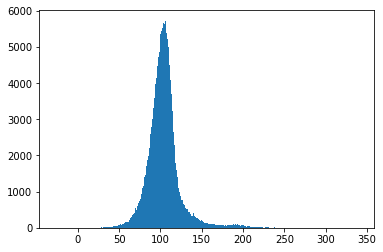

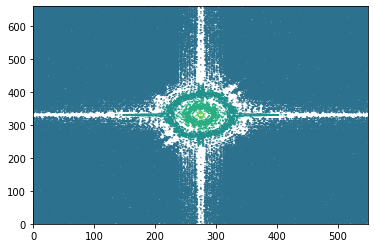

In [ ]:
_ = plt.hist(spectrum_shifted.flatten(), bins='auto')
plt.show()
_ = plt.contour(range(img_data.shape[1]), range(img_data.shape[0]), spectrum_shifted)
plt.show()

In [ ]:
# Cool so lets get some of the points that contribute a lot of signal
clip = np.percentile(f_shifted, 80)
inds = np.where(f_shifted > clip)

yi = inds[0].astype(np.float64)/img_data.shape[0]
xi = inds[1].astype(np.float64)/img_data.shape[1]
M2 = np.array([xi, yi]) * 2 * pi - pi
len_inds = M2.shape[1]
len_inds

72600

We'll repeat the process above, moving data to GPU and processing.

In [ ]:
# Fourier points
M2_gpu = gpuarray.to_gpu(M2)

# Create an array for the result on the GPU
nuf2_gpu = gpuarray.GPUArray(len_inds, dtype=np.complex128)

plan = cufinufft(2, shape, -1, tol=1e-15, dtype=M_gpu.dtype)
plan.set_pts(len_inds, M2_gpu[0], M2_gpu[1])
plan.execute(nuf2_gpu, img_data_gpu)
nuf2 = nuf2_gpu.get()

# Check the max signal strengths look reasonable
print(np.max(np.abs(nuf2)))
print(np.max(np.abs(f)))

# Create an array for the output on GPU
reconstructed_img_data_3_gpu = gpuarray.GPUArray(shape, dtype=np.complex128)

# Setup and run the plan
plan = cufinufft(1, shape, 1, tol=1e-15, dtype=np.float64)
plan.set_pts(len_inds, M2_gpu[0], M2_gpu[1])
plan.execute(nuf2_gpu, reconstructed_img_data_3_gpu)

# Copy result to host for next steps
reconstructed_img_data_3 = reconstructed_img_data_3_gpu.get()

# Again, we'll normalize it for independence on number of fourier pts
reconstructed_img_data_3 = np.real(reconstructed_img_data_3) / len_inds


24669745.999998216
24669746.0


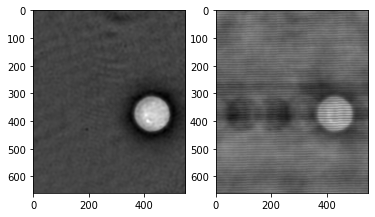

Reconstruction Close: False
Diffs l1: 116840017.03921324    l2: 215174.6877216176


In [ ]:
plt.subplot(121).imshow(reconstructed_img_data, cmap='gray')
plt.subplot(122).imshow(reconstructed_img_data_3, cmap='gray')
plt.show()

print('Reconstruction Close:', np.allclose(img_data, reconstructed_img_data_3))

diff = img_data - reconstructed_img_data_3
l1_norm = np.sum(np.abs(diff))
l2_norm = np.linalg.norm(diff)
print(f'Diffs l1: {l1_norm}    l2: {l2_norm}')


Hrmm, still not very good. I betcha could smash together some code to make a better mesh who's density is a function of the known spectrum (power), just to see how we can encode this thing... but alas it will have to wait for another day. I just wanted to make sure the image wasn't upside down and backwards for now :D. LGTM.